In [266]:
%pylab inline
import numpy as np
import pandas as pd
from enum import Enum
import heapq

Populating the interactive namespace from numpy and matplotlib


In [267]:
class PriorityQueue(object):
    def __init__(self, keyfun=None, reverse=False):
        mult = 1
        if keyfun is None:
            keyfun = lambda x: x[0]
        if reverse:
            mult = -1
        self.keyfun = lambda x: mult * keyfun(x)
        self.contents = []
        
    def enqueue(self, item):
        item = (self.keyfun(item), item)
        heapq.heappush(self.contents, item)
        
    def dequeue(self):
        if self.contents:
            item = heapq.heappop(self.contents)
            return item[1]
        return None
    
    def is_empty(self):
        return not self.contents
    
    def __len__(self):
        return len(self.contents)
    
    def __bool__(self):
        return bool(self.contents)
    
    def __repr__(self):
        return repr(self.contents)
    
    def __str__(self):
        return str(self.contents)
        

In [291]:
class Customer(object):
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time
        self.service_start_time = None 
        self.service_end_time = None 
        self.frustration = 0
        self.priority_score = min(10, max(1, int(np.random.normal(5, 2))))
        self.is_dead = False
    
    def service_start(self, time):
        self.service_start_time = time
    
    def service_end(self, time):
        self.service_end_time = time
        self.frustration += self.service_end_time  - self.arrival_time
        
    def get_wait_time(self):
        if self.service_start_time is None:
            raise ValueError("Cannot call wait time yet")
        return self.service_start_time - self.arrival_time
    
    def get_service_length(self):
        if self.service_end_time is None:
            raise ValueError("Cannot call service time yet")
        return self.service_end_time - self.service_start_time
    
    def get_time_in_system(self):
        if self.service_end_time is None:
            raise ValueError("Cannot call total time yet")
        return self.service_end_time - self.arrival_time
    
    def __lt__(self, other):
        return self.arrival_time < other.arrival_time

In [292]:
class Server(object):
    def __init__(self):
        self.is_free = True
        self.utilization_time = 0
        self.temp_time = 0
        self.customer = None
    
    def start_serving(self, time, customer):
        self.is_free = False
        self.temp_time = time
        self.customer = customer
    
    def finish_serving(self, time):
        self.is_free = True 
        self.utilization_time += (time - self.temp_time)
        self.temp_time = 0
        customer_to_return = self.customer
        self.customer = None
        return customer_to_return
        
    
    def get_utilization(self, total_time):
        return self.utilization_time / total_time

In [293]:
class EventType(Enum):
    ARRIVAL = 1
    SERVICE_START = 2
    SERVICE_END = 3
    DEATH = 4
    
def create_arrival(time):
    return (time, EventType.ARRIVAL)

def create_service_start(time):
    return (time, EventType.SERVICE_START)

def create_service_end(time, server=None):
    return (time, EventType.SERVICE_END, server)

def create_death_event(time, customer=None):
    return (time, EventType.DEATH, customer)

In [294]:
class FutureEventList(object):
    def __init__(self):
        self.events = PriorityQueue()
    
    def enqueue(self, event):
        self.events.enqueue(event)
    
    def dequeue(self):
        return self.events.dequeue()

In [295]:
class CustomerQueue(object):
    def __init__(self, can_skip=True, skipping_rate=0.5):
        self.customers = PriorityQueue(lambda cust: cust.priority_score, reverse=True)
        self.last_update = 0
        self.lengths = [0]
        self.time_held = []
        self.can_skip = can_skip
        self.skipping_rate = skipping_rate
    
#    # # # # # --> # # @ # # #
#    4 3 2 1 0 --> 5 4 3 2 1 0
    def add_customer(self, arrival_time):
        customer = Customer(arrival_time)
        new_length = self.lengths[-1] + 1
        self.lengths.append(new_length)
        self.time_held.append(arrival_time - self.last_update)
        self.last_update = arrival_time
        
        self.customers.enqueue(customer)
        return customer
        
#         customer = Customer(arrival_time)
#         new_length = self.lengths[-1] + 1
#         self.lengths.append(new_length)
#         self.time_held.append(arrival_time - self.last_update)
#         self.last_update = arrival_time
#         if np.random.random() <= self.skipping_rate and self.can_skip:
#             #print('Customer skipping ')
#             places = int(np.random.uniform(1, 5))
#             places = min(places, len(self.customers))
#             position = (len(self.customers) - places)
#             #print('Customer skipping to position ', position, ' of ', len(self.customers))
#             self.customers.insert(position, customer)
#             for i in range(position + 1, len(self.customers)):
#                 #print('Incrementing')
#                 self.customers[i].frustration += 10
#         else:
#             self.customers.append(customer)
        
    def is_empty(self):
        return not self.customers
        
    def remove_customer(self, removal_time):
        customer = self.customers.dequeue()
        #self.customers.pop(0)
        new_length = self.lengths[-1] - 1
        self.lengths.append(new_length)
        self.time_held.append(removal_time - self.last_update)
        self.last_update = removal_time
        return customer
    
    def compute_line_length_distribution(self, total_time):
        arr = []
        for count, time in zip(self.lengths, self.time_held):
            arr.append([count, time])
        df = pd.DataFrame(arr, columns=['count', 'time'])
        df = df.groupby('count').agg({'time': 'sum'}).reset_index()
        df['time'] /= total_time
        df = df.rename(columns={'time': 'p(count)'})
        return df

In [296]:
class ServerSystem(object):
    def __init__(self, num_servers=1):
        self.num_serves = num_servers
        self.servers = []
        for i in range(num_servers):
            self.servers.append(Server())
    
    def are_any_free(self):
        return any([server.is_free for server in self.servers])
    
    def get_free_server(self):
        for curr_server in self.servers:
            if curr_server.is_free:
                return curr_server
        return None
    
    def get_average_utilization(self, total_time):
        utilizations = [s.get_utilization(total_time) for s in self.servers]
        return np.mean(utilizations)

In [297]:
def get_interarrival_time():
    return np.random.uniform(0.5, 6)

def get_service_time(priority_score):
    time = None
    if priority_score <= 3:
        time = np.random.normal(10, 2)
    elif priority_score <= 6:
        time = np.random.normal(20, 4)
    else:
        time = np.random.normal(30, 4)
    return max(5, time)


def get_time_to_die(priority_score):
    time = None
    if priority_score <= 3:
        time = np.random.normal(7 * 24 * 60, 10)
    elif priority_score <= 6:
        time = np.random.normal(7 * 60, 60)
    else:
        time = np.random.normal(60, 30)
    return max(30, time)
        

In [304]:
def simulate_er(customer_limit, num_servers=1, 
                            can_skip=True, skipping_rate=0.5):
    customer_queue = CustomerQueue()
    vendors = ServerSystem(num_servers)
    fel = FutureEventList()
    num_customers_to_arrive = 0
    finished_customers = []
    
    # our first arrival
    interarrival_time = get_interarrival_time()
    first_arrival_time = 0 + interarrival_time
    first_arrival = create_arrival(first_arrival_time)
    fel.enqueue(first_arrival)
    last_time = 0
    death_counter = 0

    
    while num_customers_to_arrive <= customer_limit:
        current_event = fel.dequeue()
        current_time = current_event[0]
        last_time = current_time
        current_event_type =  current_event[1]
        if current_event_type == EventType.ARRIVAL:
            customer = customer_queue.add_customer(current_time)
            death_event = create_death_event(get_time_to_die(customer.priority_score), customer)
            fel.enqueue(death_event)
            num_customers_to_arrive += 1
            if vendors.are_any_free():
                vendor = vendors.get_free_server()
                customer = customer_queue.remove_customer(current_time)
                customer.service_start(current_time)
                vendor.start_serving(current_time, customer)
                service_time = get_service_time(customer.priority_score)
                completion_of_service_time = current_time + service_time
                new_event = create_service_end(completion_of_service_time, vendor)
                fel.enqueue(new_event)
            interarrival_time = get_interarrival_time()
            next_arrival_time = interarrival_time + current_time
            new_event = create_arrival(next_arrival_time)
            fel.enqueue(new_event)
        elif current_event_type == EventType.SERVICE_END:
            vendor = current_event[2]
            customer = vendor.finish_serving(current_time)
            finished_customers.append(customer)
            customer.service_end(current_time)
            while not customer_queue.is_empty():
                customer = customer_queue.remove_customer(current_time)
                if not customer.is_dead:
                    customer.service_start(current_time)
                    vendor.start_serving(current_time, customer)
                    service_time = get_service_time(customer.priority_score)
                    completion_of_service_time = current_time + service_time
                    new_event = create_service_end(completion_of_service_time, vendor)
                    fel.enqueue(new_event)
                    break
        elif current_event_type == EventType.DEATH:
            if customer.service_start_time is None:
                death_counter += 1
                customer.is_dead = True
        
    return customer_queue, vendors, finished_customers, last_time, death_counter

In [305]:
customer_queue, vendors, finished_customers, last_time, death_counter = simulate_er(1000, 10)

In [306]:
death_counter

2

In [307]:
dc = []
for i in range(2, 21):
    print('Considering ', i, ' doctors')
    customer_queue, vendors, finished_customers, last_time, death_counter = simulate_er(5000, i)
    dc.append(death_counter)
    #wait_times = [cust.get_wait_time() for cust in finished_customers]
    #average_wait_times.append(np.mean(wait_times))

Considering  2  doctors
Considering  3  doctors
Considering  4  doctors
Considering  5  doctors
Considering  6  doctors
Considering  7  doctors
Considering  8  doctors
Considering  9  doctors
Considering  10  doctors
Considering  11  doctors
Considering  12  doctors
Considering  13  doctors
Considering  14  doctors
Considering  15  doctors
Considering  16  doctors
Considering  17  doctors
Considering  18  doctors
Considering  19  doctors
Considering  20  doctors


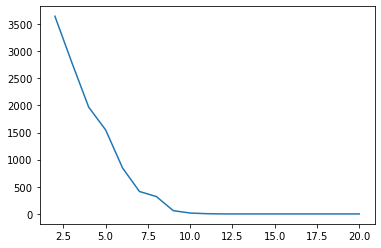

In [308]:
plt.plot(list(range(2, 21)), dc)

In [309]:
dc

[3643, 2790, 1966, 1548, 847, 413, 320, 60, 16, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [257]:
customer_queue.compute_line_length_distribution(last_time)

,count,p(count)
0,0,0.998484
1,1,0.001384
2,2,0.000132


In [258]:
vendors.get_average_utilization(last_time)

0.5596824826482132

In [259]:
wait_times = [cust.get_wait_time() for cust in finished_customers]
print(np.mean(wait_times))

0.005421676737609964


In [260]:
system_times = [cust.get_time_in_system() for cust in finished_customers]
print(np.mean(system_times))

18.424321034767754


(array([32., 36., 41., 33., 33., 39., 34., 40., 38., 33.]),
 array([  12.85398193,  229.09194621,  445.32991048,  661.56787475,
         877.80583903, 1094.0438033 , 1310.28176758, 1526.51973185,
        1742.75769612, 1958.9956604 , 2175.23362467]),
 <a list of 10 Patch objects>)

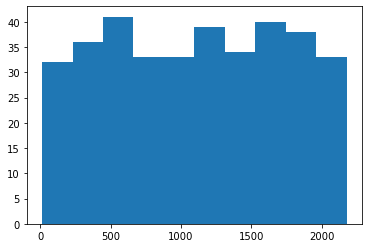

In [255]:
plt.hist(system_times)